# Notebook de test des données lapi post-traitees

In [1]:
%load_ext autoreload
%autoreload 
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import Connexion_Transfert as ct
import donnees_posttraitees as t
import graphs as g
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 50)
#alt.data_transformers.enable('default', max_rows=None)
import os, math, re
from sklearn.cluster import DBSCAN
from sklearn import svm,datasets
import matplotlib.pyplot as plt

# 1. import des données, traitement de mise en forme
## 1.1 Import
Les données sont importées sur la période du 24/01/19 au 23/02/19, sur laquelle il n'y a pas de manque de données à priori

In [2]:
%time df_passages, df_plaques, df_immat=t.ouvrir_fichier_lapi_final('2019-01-23 00:00:00','2019-02-13 23:59:59')

Wall time: 3min 16s


## 1.2. Suppression des doublons

### 1.2.1 Doublons

In [3]:
%time df_passages=t.supprimer_doublons(df_passages)

Wall time: 1min 18s


### 1.2.2 passages proches

In [4]:
%time groupe_pl_rappro, groupe_pl=t.passages_proches(df_passages4)

NameError: name 'df_passages4' is not defined

In [212]:
groupe_pl_rappro.head(5)#.to_csv(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\lapi_passages_proches.csv')

,camera_id,created,state,fiability,erreur_tps_passage,liste_passag_faux,liste_created_faux,fiability_faux
immat,,,,,,,,
001b3fc1839070936df83443270d62a53becc9db,"(4, 10, 5, 6, 3)","(2019-01-31 09:49:36, 2019-01-31 09:51:11, 2019-01-31 10:01:30, 2019-02-11 02:56:16, 2019-02-11 03:08:05)",FR,"(99, 99, 99, 99, 99)",True,"(4, 10)","(2019-01-31 09:49:36, 2019-01-31 09:51:11)","(99, 99)"
0028f8fa0d1dc22e6eb4c1c57d0caeb1efb0fbfb,"(10, 4, 5, 11, 12, 6, 3)","(2019-02-01 06:33:08, 2019-02-01 06:34:47, 2019-02-01 06:47:25, 2019-02-01 07:13:12, 2019-02-04 15:58:51, 2019-02-04 16:19:22, 2019-02-04 16:32:22)",PL,"(99, 99, 99, 99, 89, 79, 99)",True,"(10, 4)","(2019-02-01 06:33:08, 2019-02-01 06:34:47)","(99, 99)"
005728f228714ee3a531f3b6cae08f9c8c2f21e7,"(3, 9, 10, 4, 7, 8, 6, 3, 4, 5, 6, 3, 4, 12, 3, 9, 4, 10, 7, 8, 6, 3, 4, 3, 9, 4, 10, 7, 8, 7, 8, 6, 3, 4, 3, 9, 4, 10, 5, 6, 3, 4, 3, 9)","(2019-01-31 03:07:45, 2019-01-31 03:18:46, 2019-01-31 08:01:01, 2019-01-31 08:11:26, 2019-01-31 09:56:02, 2019-01-31 14:46:09, 2019-02-01 05:14:30, 2019-02-01 05:26:52, 2019-02-01 06:58:54, 2019-02-01 07:12:15, 2019-02-01 08:22:55, 2019-02-01 08:49:18, 2019-02-01 10:15:13, 2019-02-01 15:19:31, 2019-02-04 05:32:59, 2019-02-04 05:44:15, 2019-02-04 08:56:50, 2019-02-04 09:07:28, 2019-02-04 10:41:33, 2019-02-04 15:51:48, 2019-02-05 04:38:55, 2019-02-05 04:50:53, 2019-02-05 06:38:37, 2019-02-06 05:34:44, 2019-02-06 05:46:25, 2019-02-06 09:11:02, 2019-02-06 09:22:20, 2019-02-07 04:45:32, 2019-02-07 09:49:13, 2019-02-07 11:16:00, 2019-02-07 14:38:11, 2019-02-08 04:16:42, 2019-02-08 04:28:55, 2019-02-08 06:02:46, 2019-02-08 07:55:51, 2019-02-08 08:19:29, 2019-02-08 12:48:02, 2019-02-08 12:58:30, 2019-02-08 12:59:39, 2019-02-08 14:00:29, 2019-02-08 14:12:31, 2019-02-08 15:46:47, 2019-02-11 04:20:11, 2019-02-11 04:30:08)",FR,"(99, 99, 99, 99, 99, 99, 99, 89, 99, 99, 99, 99, 99, 99, 99, 99, 89, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 89, 99, 99, 99, 68, 99, 99, 89, 99, 99, 99, 99, 89, 99, 99)",True,"(10, 5)","(2019-02-08 12:58:30, 2019-02-08 12:59:39)","(99, 99)"
005a9f27ff36441aab778af90e3d145f0d12cf60,"(4, 18, 9, 19, 18, 3, 9, 3, 3, 6, 10, 10, 4, 4, 7, 18, 3, 18, 3, 4, 3, 3, 8, 12, 6, 6, 10, 6, 18, 12, 12, 4, 5, 6, 3, 10, 3, 3, 18, 3, 13, 13, 18, 3, 8, 9, 12, 4, 3, 4, 5, 15, 12, 18, 6, 12, 7, 3, 18, 12, 5)","(2019-01-31 09:03:37, 2019-01-31 09:03:59, 2019-01-31 09:09:02, 2019-01-31 10:11:03, 2019-01-31 10:40:07, 2019-01-31 13:36:21, 2019-02-01 08:15:30, 2019-02-01 08:25:27, 2019-02-01 08:46:15, 2019-02-01 09:04:50, 2019-02-01 09:06:34, 2019-02-01 09:18:59, 2019-02-01 13:23:39, 2019-02-01 14:34:16, 2019-02-01 15:28:48, 2019-02-02 15:20:09, 2019-02-03 11:41:58, 2019-02-03 16:10:12, 2019-02-04 04:25:40, 2019-02-04 09:22:44, 2019-02-04 09:40:17, 2019-02-04 10:12:15, 2019-02-04 11:39:46, 2019-02-04 14:30:28, 2019-02-05 11:56:10, 2019-02-05 14:03:54, 2019-02-05 16:13:16, 2019-02-06 07:42:59, 2019-02-06 08:57:28, 2019-02-06 09:56:46, 2019-02-06 11:34:20, 2019-02-06 13:55:23, 2019-02-06 13:59:20, 2019-02-06 16:28:47, 2019-02-07 07:36:04, 2019-02-07 07:50:05, 2019-02-07 10:36:38, 2019-02-07 11:11:06, 2019-02-07 14:10:41, 2019-02-08 08:59:31, 2019-02-08 09:21:07, 2019-02-08 09:27:05, 2019-02-08 11:43:00, 2019-02-08 11:50:02, 2019-02-08 12:07:38, 2019-02-08 12:54:36, 2019-02-08 13:25:37, 2019-02-...",BE,"(79, 89, 79, 89, 99, 79, 88, 99, 88, 79, 99, 89, 89, 99, 79, 88, 88, 99, 99, 89, 89, 99, 89, 99, 89, 88, 99, 89, 79, 79, 99, 89, 99, 89, 79, 89, 88, 89, 89, 99, 99, 89, 89, 99, 89, 89, 88, 99, 89, 79, 79, 79, 88, 79, 99, 79, 89, 79, 88, 89, 99)",True,"(4, 18, 6, 10, 4, 5, 3, 18)","(2019-01-31 09:03:37, 2019-01-31 09:03:59, 2019-02-01 09:04:50, 2019-02-01 09:06:34, 2019-02-06 13:55:23, 2019-02-06 13:59:20, 2019-02-11 15:33:47, 2019-02-11 15:38:17)","(79, 89, 79, 99, 89, 99, 79, 88)"
00622c245465b6ea42b3b03da48b2776f93f8754,"(6, 2, 9, 4, 10, 5, 11)","(2019-02-07 12:26:06, 2019-02-07 14:50:28, 2019-02-07 15:05:28, 2019-02-08 07:30:18, 2019-02-08 07:30:37, 2019-02-08 07

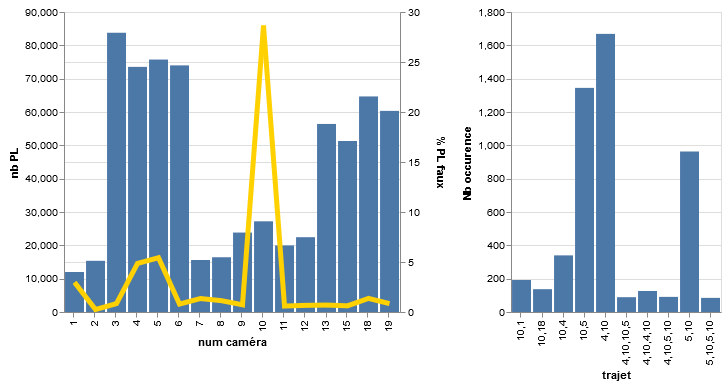

In [215]:
jointure = g.analyse_passage_proches(groupe_pl_rappro, groupe_pl)
g.graph_passages_proches(jointure, groupe_pl_rappro)

## 1.3 Ajout de l'attribut de différenciation VL / PL

In [4]:
%time df_passages2=t.affecter_type(df_passages,df_immat)

Wall time: 4min 1s


In [5]:
%time df_passages3=t.affecter_type_nuit(df_passages2,df_immat)

Wall time: 21.8 s


In [6]:
len(df_passages2.loc[df_passages2['l']==1])

688958

In [7]:
len(df_passages3.loc[df_passages3['l']==1])

### différenciation VL / PL

In [437]:
df_passages4=df_passages3.loc[df_passages3['l']==1].copy()

***ATTENTION : ENCORE 18764 IMMATRCULATION COURTE PRESENTES DANS TE_PASSAGES ET NON PRENSENTES DANS TE_PLAQUES_COURTE :***

In [69]:
df_passages2.loc[df_passages2.immatriculation.isna()].merge(df_plaques, left_on='immat', right_on='chiffree').to_csv(
    r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\immatriculation_manquante.csv')

***ATTENTION : PLUS DE 1M DE PASSAGES SANS VALEUR DE VL_TOT ou PL_TOT ou VUL_TOT :***

In [183]:
#nb de passages avec un type inconnu
passages_type_inconnu=(df_passages3.loc[df_passages3['l']==-1]).reset_index()#.head(20)

In [184]:
#passages inconnu avec une fiabilite superieure a 75 sur cam autre que 1ou2 et fiab > 35 sr cam 1 et 2
passages_type_inconnu_fiab_sup75=(passages_type_inconnu.loc[((passages_type_inconnu['fiability']>75) & (~passages_type_inconnu['camera_id'].isin([1,2]))) |
                                                            ((passages_type_inconnu['fiability']>35) & (passages_type_inconnu['camera_id'].isin([1,2])))])

In [185]:
len(passages_type_inconnu_fiab_sup75)

232939

In [167]:
groupe=(passages_type_inconnu_fiab_sup75.set_index('created').sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 
                                                                                 'created':lambda x: tuple(x), 
                                                                                 'state': lambda x : set(tuple(x))}))

In [168]:
groupe_filtre=groupe.loc[groupe.apply(lambda x: (all((pd.to_datetime(e).hour>19 or pd.to_datetime(e).hour<7) for e in x['created'])) &
                        (x['camera_id'] in t.liste_complete_trajet.cameras.tolist()) & (len(x['state'])==1) & 
                        (x['state']!=set(['FR',])) ,axis=1)].copy()

In [169]:
groupe_filtre=groupe_filtre.loc[~groupe_filtre.apply(lambda x: [(a) for a in x['state']]==['  '],axis=1)]
groupe_filtre

,camera_id,created,state
immat,,,
001e325735145d38489dc2bec097cc10d3294386,"(12, 6, 3, 18)","(2019-02-10 00:45:53, 2019-02-10 01:07:47, 2019-02-10 01:20:05, 2019-02-10 01:39:53)",{NL}
00211a77de4f1d952d0384090f231efd091e4805,"(19, 5)","(2019-02-02 21:19:14, 2019-02-02 21:42:47)",{ES}
0028aa39418784ac9abe4f9cb52dd8d732ec58aa,"(6, 3, 18)","(2019-02-05 21:33:17, 2019-02-05 21:44:15, 2019-02-05 22:00:16)",{NL}
00800ead14cca17cea7df922087f1f0fd35af0e7,"(19, 5)","(2019-02-07 22:07:14, 2019-02-07 22:36:05)",{PL}
009f5722e10075e77b58bd067f419d116c3c272f,"(19, 4, 5)","(2019-02-06 20:54:24, 2019-02-06 21:11:11, 2019-02-06 21:26:19)",{PL}
012454c49cc65806d25a0d3641f3e899d1948465,"(12, 6, 3, 18)","(2019-02-09 03:16:46, 2019-02-09 03:26:52, 2019-02-09 03:36:49, 2019-02-09 03:52:01)",{NL}
012f57273420b5ff3dc07881350e6ce368de9fbc,"(12, 6, 3, 18)","(2019-02-09 01:34:09, 2019-02-09 01:45:03, 2019-02-09 01:54:23, 2019-02-09 02:19:40)",{PT}
0181bd66684bad32c89ff81f0077edf6a426be16,"(6, 3, 18)","(2019-02-01 05:01:51, 2019-02-01 05:14:28, 2019-02-01 06:04:26)",{BE}
021c276fb5eeeba9ff761ee23454c51635b22eef,"(6, 3, 18)","(2019-02-08 22:23:02, 2019-02-08 22:34:45, 2019-02-08 22:53:40)",{BE}


In [141]:
df_passages2.loc[df_passages2['immat'].isin(groupe_filtre.index.tolist()),'l']=1

In [18]:
#premier exemple : cas de vl_total et vul_total rempli : il faut modifier la condition et ne pas interroger les attributs _total mais bien les attributs source
df_immat.loc[df_immat['immatriculation']=='b86a39d29995c8839d934989cc90d9a48f114ca4']

,id,immatriculation,pl_siv,pl_3barriere,pl_2barriere,pl_mmr75,pl_1barriere,pl_3camera,pl_2camera,pl_1camera,vul_siv,vul_mmr75,vl_siv,vl_mmr75,vl_3camera,vl_2camera,vl_1camera,pl_total,vul_total,vl_total,mot,type_veh
2549004,1914544,b86a39d29995c8839d934989cc90d9a48f114ca4,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,128,32,360480,-1


In [19]:
#deuxieme exemple : cas de aucun attributs rempli : on laisse à -1
df_immat.loc[df_immat['immatriculation']=='cb12765d8b9f8a6d8d11e7ea1a384272466c2324']

,id,immatriculation,pl_siv,pl_3barriere,pl_2barriere,pl_mmr75,pl_1barriere,pl_3camera,pl_2camera,pl_1camera,vul_siv,vul_mmr75,vl_siv,vl_mmr75,vl_3camera,vl_2camera,vl_1camera,pl_total,vul_total,vl_total,mot,type_veh
2578051,2109090,cb12765d8b9f8a6d8d11e7ea1a384272466c2324,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,262144,-1


In [24]:
#3eme exemple : cas de vl_total et vul_total rempli : véhicules étranger passés de nuit
df_immat.loc[df_immat['immatriculation']=='4a2c8c1847e2bc4143e2dc51636eef039182203c']

,id,immatriculation,pl_siv,pl_3barriere,pl_2barriere,pl_mmr75,pl_1barriere,pl_3camera,pl_2camera,pl_1camera,vul_siv,vul_mmr75,vl_siv,vl_mmr75,vl_3camera,vl_2camera,vl_1camera,pl_total,vul_total,vl_total,mot,type_veh
2643381,770228,4a2c8c1847e2bc4143e2dc51636eef039182203c,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,262144,-1


In [29]:
#4eme exemple : cas de 9l_total et vul_total rempli : véhicules étranger passés de nuit
df_immat.loc[df_immat['immatriculation']=='4a2c8c1847e2bc4143e2dc51636eef039182203c']

,id,immatriculation,pl_siv,pl_3barriere,pl_2barriere,pl_mmr75,pl_1barriere,pl_3camera,pl_2camera,pl_1camera,vul_siv,vul_mmr75,vl_siv,vl_mmr75,vl_3camera,vl_2camera,vl_1camera,pl_total,vul_total,vl_total,mot,type_veh
2643381,770228,4a2c8c1847e2bc4143e2dc51636eef039182203c,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,262144,-1


In [173]:
#localisation dans le fichier des passages
df_passages3.loc[df_passages3['immat']=='4a2c8c1847e2bc4143e2dc51636eef039182203c']

## 1.4. Filtre des immatriculations non cohérentes

In [442]:
df_passages5, df_immat_suppr=t.filtre_plaque_non_valable(df_passages4, df_plaques)

In [444]:
# ratio de passages suppr : 
(len(df_passages4)-len(df_passages5))*100/len(df_passages4)

## 1.5 Redressement des timestamps de la camera 10

In [479]:
df_passages6=df_passages4.reset_index().copy()
df_passages6.loc[df_passages6['camera_id']==10,'created']=df_passages6.apply(lambda x : x['created']-pd.Timedelta('25min'),axis=1)
df_passage6=df_passages6.set_index('created').sort_index().drop(['index','test']

In [484]:
df_passages6.sort_index(inplace=True)

# 2. Identifier les trajets de transit

In [485]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-31 00:00:00',11,df_passages6)

date : 2019-01-31 00:00:00 debut_traitement : 2019-05-22 09:33:47.880627
date : 2019-02-01 00:00:00 debut_traitement : 2019-05-22 09:34:59.573246
date : 2019-02-02 00:00:00 debut_traitement : 2019-05-22 09:35:56.957710
date : 2019-02-03 00:00:00 debut_traitement : 2019-05-22 09:36:48.787810
date : 2019-02-04 00:00:00 debut_traitement : 2019-05-22 09:37:31.496284
date : 2019-02-05 00:00:00 debut_traitement : 2019-05-22 09:38:45.541382
date : 2019-02-06 00:00:00 debut_traitement : 2019-05-22 09:40:13.520690
date : 2019-02-07 00:00:00 debut_traitement : 2019-05-22 09:41:35.048392
date : 2019-02-08 00:00:00 debut_traitement : 2019-05-22 09:43:10.211640
date : 2019-02-09 00:00:00 debut_traitement : 2019-05-22 09:44:44.346073
date : 2019-02-10 00:00:00 debut_traitement : 2019-05-22 09:46:09.406482


# 3. Filtrer les trajets selon un temps de parcours

In [486]:
#df des temsp de parcours
dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

In [492]:
dixco_tpsmax_corrige.head(5)

,date,temps,type,o_d
1,2019-01-31 00:00:00,00:46:57,Cluster,A10-A62
15,2019-01-31 01:00:00,00:44:51,Cluster,A10-A62
33,2019-01-31 02:00:00,00:36:06,Cluster,A10-A62
48,2019-01-31 03:00:00,00:45:20,moyenne Cluster,A10-A62
64,2019-01-31 04:00:00,00:54:34,Cluster,A10-A62


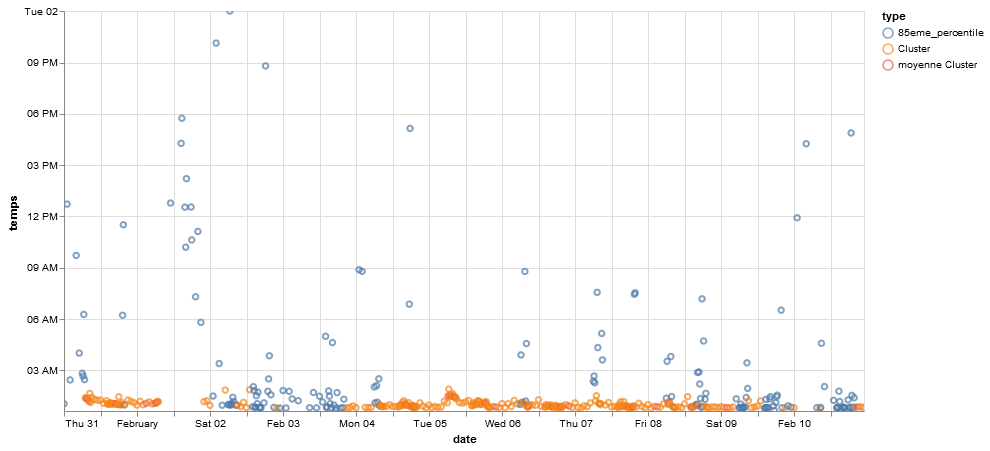

In [508]:
pour_graph=dixco_tpsmax_corrige.copy()
pour_graph.temps=pd.to_datetime('2018-01-01')+pour_graph.temps
alt.Chart(pour_graph.loc[pour_graph['o_d']=='A62-A10']).mark_point().encode(
    x='date',
    y='temps',
    color='type').properties(
    width=800,
    height=400
).interactive()

***Ici on pourra caracteriser l'impact de la marge***

In [1249]:
# df complete avec l'atribut filtre
%time df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,t.liste_complete_trajet, 15)

Wall time: 1min 25s


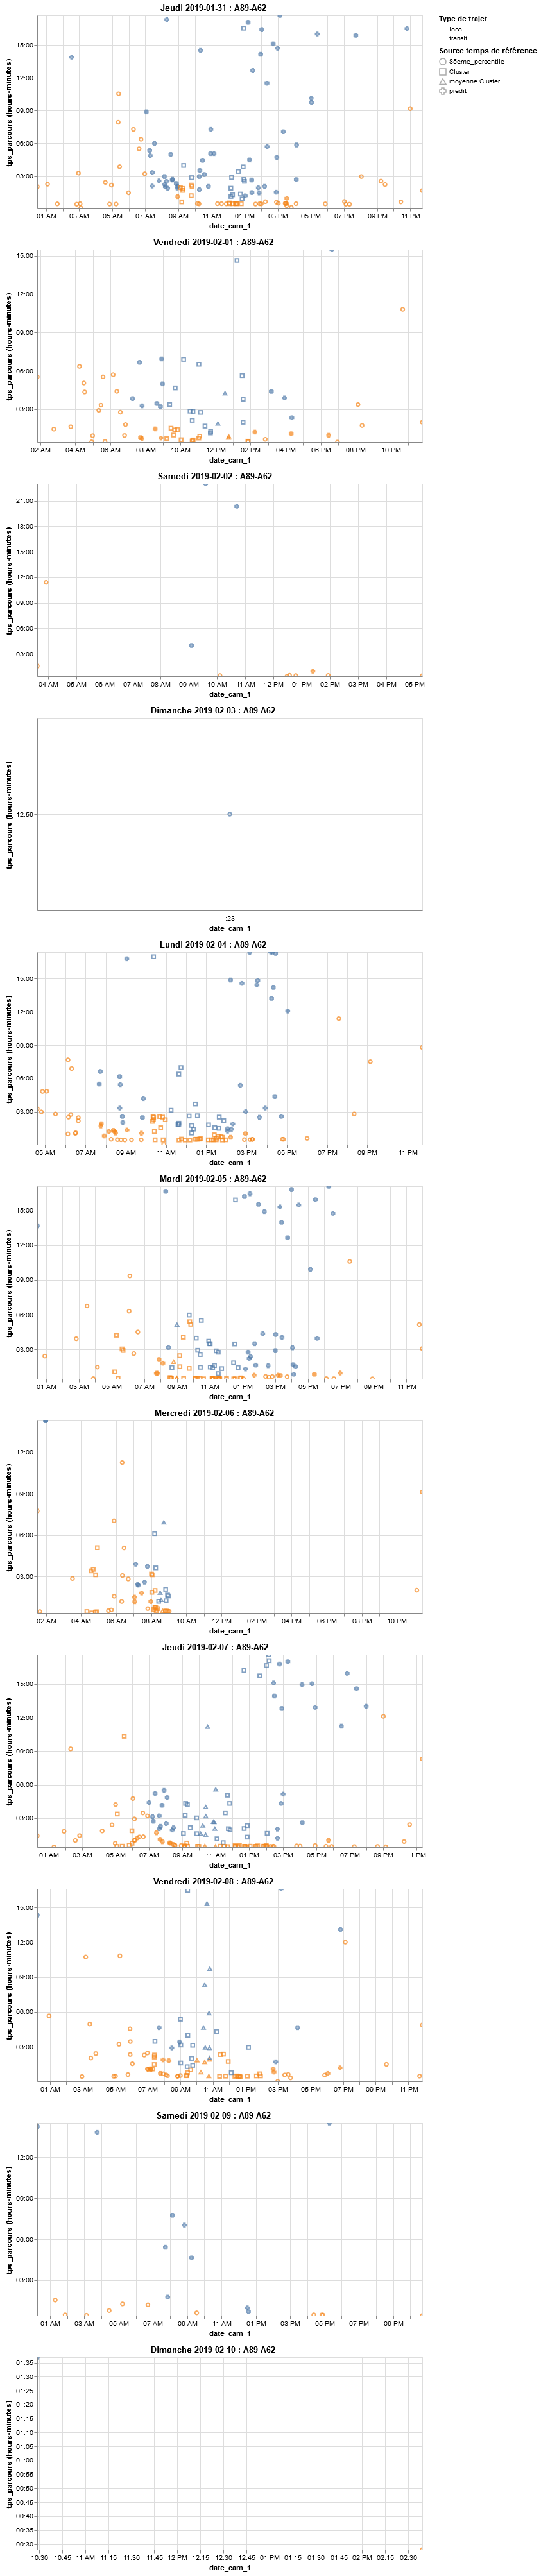

In [1263]:
#exemple de visu sur 7 jours
g.graph_transit_filtre_multiple(df_transit_avec_filtre, 
                                '2019-01-31 00:00:00', '2019-01-31 23:59:59', 'A89-A62', 11)

In [13]:
#filtrer le df : 
dico_od_final=df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]
dico_passag_final=t.trajet2passage(dico_od_final,dico_passag)

# 4. Correction des trajets depuis ou vers A660 relatifs à A63

In [14]:
%time df_od_corrige=t.correction_trajet(df_passages2, dico_od_final)

Wall time: 21min 10s


# 5. Extrapolation des trajets non complets

In [15]:
#creer les donnees necessaires
%time df_filtre_A63,df_passage_transit,df_non_transit=t.param_trajet_incomplet('2019-01-28 00:00:00',df_od_corrige,df_passages2,dico_passag)

Wall time: 59.1 s


In [18]:
#trajet de transit incomplet sans filtre sur temps de parcours
%time trajet_transit_incomplet2, passage2=t.transit_trajet_incomplet(df_filtre_A63,df_passage_transit,'2019-01-31 00:00:00',11, df_passages2)

date : 2019-01-31 00:00:00 debut_traitement : 2019-05-16 21:13:50.615971
date : 2019-02-01 00:00:00 debut_traitement : 2019-05-16 21:15:37.979249
date : 2019-02-02 00:00:00 debut_traitement : 2019-05-16 21:16:40.077915
date : 2019-02-03 00:00:00 debut_traitement : 2019-05-16 21:17:03.510637
date : 2019-02-04 00:00:00 debut_traitement : 2019-05-16 21:17:23.077283
date : 2019-02-05 00:00:00 debut_traitement : 2019-05-16 21:18:07.226284
date : 2019-02-06 00:00:00 debut_traitement : 2019-05-16 21:19:00.164409
date : 2019-02-07 00:00:00 debut_traitement : 2019-05-16 21:19:45.334828
date : 2019-02-08 00:00:00 debut_traitement : 2019-05-16 21:20:19.822434
date : 2019-02-09 00:00:00 debut_traitement : 2019-05-16 21:20:45.965237
date : 2019-02-10 00:00:00 debut_traitement : 2019-05-16 21:21:02.941735
Wall time: 7min 28s


In [19]:
#filtrer selon le temps de parcours
trajet_transit_incomplet_filtre_temps=t.jointure_temps_reel_theorique(trajet_transit_incomplet2,dixco_tpsmax_corrige,t.liste_trajet_incomplet, 15,'incomplet')
#mettre en forme les attributs
trajet_transit_incomplet_filtre_temps=trajet_transit_incomplet_filtre_temps[['date_cam_1', 'immat', 'state', 'l', 'date_cam_2', 'cameras', 'origine',
       'destination', 'o_d', 'tps_parcours', 'period', 'date', 'temps', 'type',
       'tps_parcours_theoriq', 'filtre_tps']]

In [20]:
#filtrer le df : 
trajet_transit_incomplet_final=trajet_transit_incomplet_filtre_temps.loc[trajet_transit_incomplet_filtre_temps['filtre_tps']==1].copy()
#ajouter l'attribut d'identification des trajets 
trajet_transit_incomplet_final['correction_o_d']=True
trajet_transit_incomplet_final['correction_o_d_type']='extrapole'
#6. Ajouter au df des o_d précédents : 
df_od_final=pd.concat([df_od_corrige,trajet_transit_incomplet_final],sort=False)

# 6. Créer le tableaude matrice o_d

In [21]:
# de base
pd.pivot_table(dico_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,2965,4485,1062,168,NC,8680
A62,1205,NC,168,413,271,1372,3429
A63,3625,106,NC,NC,779,19194,23704
A660,1108,389,NC,NC,525,5105,7127
A89,133,384,1044,596,NC,NC,2157
N10,NC,2412,20275,4386,NC,NC,27073
All,6071,6256,25972,6457,1743,25671,72170


In [22]:
# apres correction des A660 liees a A63
pd.pivot_table(df_od_corrige,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,2965,4753,794,168,NC,8680
A62,1205,NC,198,383,271,1372,3429
A63,3806,123,NC,NC,842,20183,24954
A660,927,372,NC,NC,462,4116,5877
A89,133,384,1147,493,NC,NC,2157
N10,NC,2412,21766,2895,NC,NC,27073
All,6071,6256,27864,4565,1743,25671,72170


In [23]:
# apres extrapolation
pd.pivot_table(df_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,2974,4753,794,168,NC,8689
A62,1205,NC,198,383,271,1373,3430
A63,3806,123,NC,NC,843,20192,24964
A660,927,372,NC,NC,462,4116,5877
A89,133,385,1147,493,NC,NC,2158
N10,NC,2414,21766,2895,NC,NC,27075
All,6071,6268,27864,4565,1744,25681,72193


In [27]:
# O-D apres extrapolation en moyenne sur jour ouvre
df_od_ouvre_final=df_od_final.loc[df_od_final.set_index('date_cam_1').index.dayofweek<5]
pivot_od_jo=pd.pivot_table(df_od_ouvre_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')
pivot_od_jo

In [38]:
pivot_od_jo.applymap(lambda x : x/5 if (isinstance(x,float) or isinstance(x,int)) else 'NC')
#pivot_od_jo.applymap(lambda x : type(x))

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,525.6,716.2,126.4,31.8,NC,1400.0
A62,223.8,NC,36.2,75,50.8,262.4,648.2
A63,560.2,23,NC,NC,139.6,2869.2,3592.0
A660,166.2,70.2,NC,NC,87.6,721.8,1045.8
A89,24.8,73.4,189,90.2,NC,NC,377.4
N10,NC,438.8,3117.8,429.4,NC,NC,3986.0
All,975,1131,4059.2,721,309.8,3853.4,11049.4


# 7. Différeciation Rocade Est-Ouest
>Cette analyse ne concerne que les trajets N10-A63, A10-A63, N10-A660, A10-A660

In [77]:
??t.differencier_rocade

Object `t.differencier_rocade` not found.


In [57]:
pivot_type_rocade

type_rocade,Autre,Est,Ouest,All
o_d,,,,
A10-A63,474,4126,153,4753
A10-A660,159,597,38,794
A63-A10,715,3053,38,3806
A660-A10,248,669,10,927
A660-N10,1184,2892,40,4116
N10-A63,2106,19016,644,21766
N10-A660,589,2205,101,2895
All,5475,32558,1024,39057


# 7. Analyse du nb de VL, PL, PL en transit par heure et par camera 
> Le pb c'est que pour les camera de la Rocade, parfois on les PL n'y sont pas vus, de même pour les chemins extrapoles ou pour ceux corrigés : le passage soit n'existe pas, soit la camera du passage ne correspond pas à la destination finalement utilisées

## 7.1 base : travail sur les données telles que créees

In [48]:
df_vl=df_passages2.loc[df_passages2['l']!=1]
df_pl=df_passages2.loc[df_passages2['l']==1]
#df_passages_transit=t.trajet2passage(dico_od_final,df_pl) deféini plus haut :dico_passag_final

In [49]:
%time synt_nb_veh_cam=t.pourcentage_pl_camera(df_pl,dico_passag_final, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.51 s


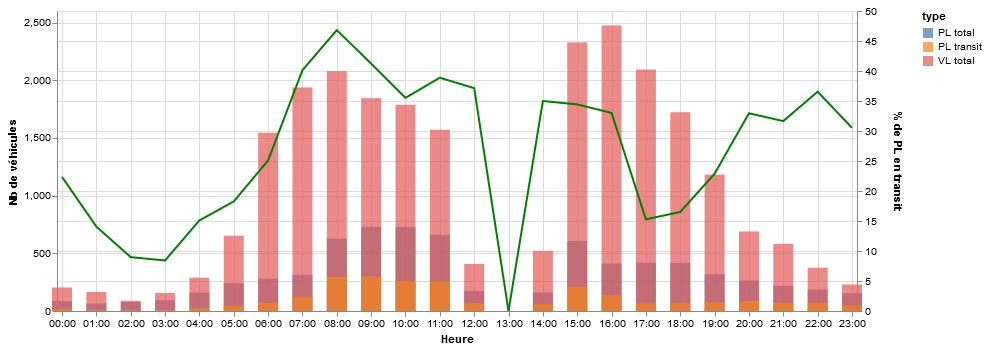

In [52]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-29', 4)

## 7.2 Redressement au niveau de la Rocade

In [126]:
#determiner les passages fictifs
df_passage_transit_redresse, df_pl_redresse, trajets_rocade_non_vu=t.passages_fictif_rocade (t.liste_trajet_rocade, dico_od_final,dico_passag_final,df_pl)
#regrouper
%time synt_nb_veh_cam_redresse=t.pourcentage_pl_camera(df_pl_redresse,df_passage_transit_redresse, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.3 s


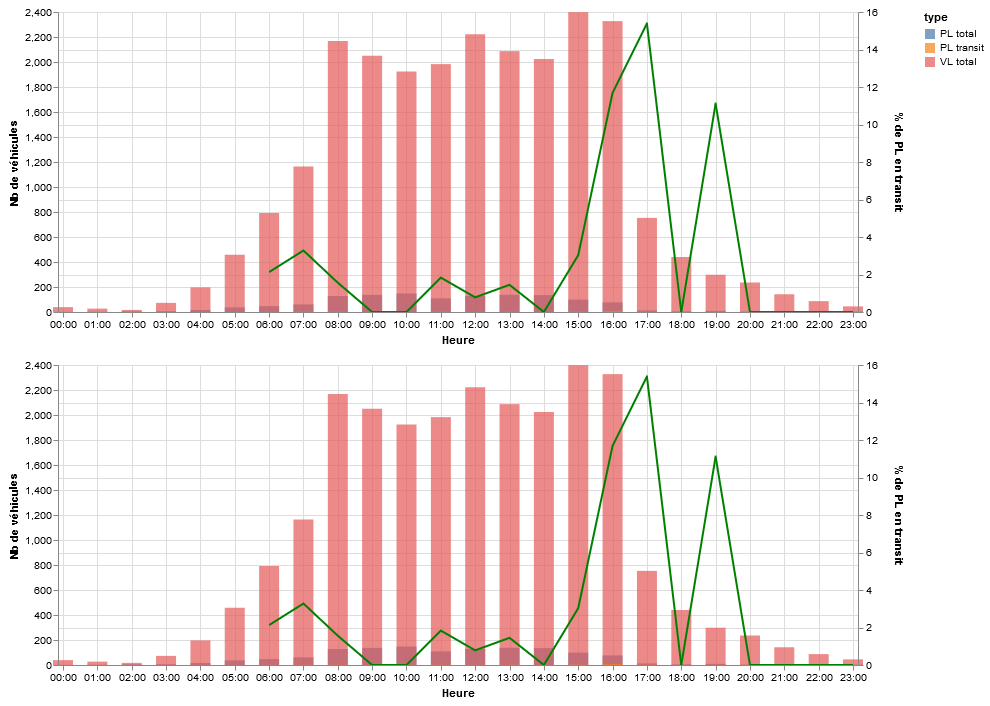

In [46]:
alt.vconcat(g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-28', 1),g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, '2019-01-28', 1))

## 7.3 Redressement des trajets extrapoles

>**A TESTER SUR JEU DE DONNEES COMPLET**

In [ ]:
# de même que opur la rocade, il faut ajouter des passages fictifs à la df des passages afin de pouvoir approximer mieux les parts de PL
#trouver les passages extrapoles
df_od_final.loc[df_od_final['correction_o_d_type']=='extrapole']
# tester la camera de debut :si c'est pas une des cameras d'entree - sortie du dispositif, on sait si le trajet est extrapole en début ou fin
#selon l'o_d crééer un passage fictuf avec le numero de la camera qui manque du trajets sensé avoir eu leiu
#estimer le temps de passage selon le temps theorique : date_cam_1 ou 2 +ou- temps ou temps theorique

## 7.4. Grouper les réusltats par JO

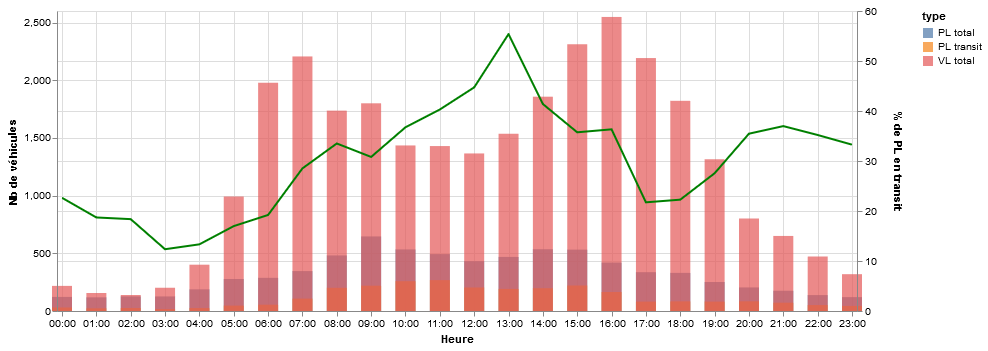

In [133]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, 'JO', 4)

# 8. Temps de parcours

In [26]:
# on cherche à obtenir le temps de parcours moyen pour une camera, sur un jour ou les jours ouvres, par o_d
# on construit donc une df avec : immat, cam, tps_parcours, heure_Rocade
# pour l'heure à la Rocade : on va cehrcher dans les df_passage le passage:qui a la mm immat, dont la cam est 1,2,3,4 et dont le created est compris entre date_cam1et date_cam2

#isoler les passages concernes par la Rocade
passage_rocade=dico_passag_final.loc[(dico_passag_final['camera_id'].isin([1,2,3,4]))]# & (dico_passag_final['correction_o_d']==False)]

In [36]:
#jointure entre les o_d et les passages
o_d_joint_rocade=dico_od_final.merge(passage_rocade, on='immat', how='left')

In [109]:
#limiter les o_d là ou date du passages est ciompris entre les date 1 et date 2 de l'o_d
dico_od_Rocade_final=o_d_joint_rocade.loc[(o_d_joint_rocade['date_cam_1']<o_d_joint_rocade['created']) & 
                                          (o_d_joint_rocade['created']<o_d_joint_rocade['date_cam_2']) & 
                                          (o_d_joint_rocade['tps_parcours']<pd.Timedelta('4H'))]

In [155]:
#limiter les 
limite_donnees=dico_od_Rocade_final[['date_cam_1','immat','o_d','tps_parcours','created']].rename(columns={'created':'h_rocade'})

In [181]:
#filtrer selon une date ou des jours ouvrés ou mardi/jeudi : 
"""filtre_donnees=limite_donnees.loc[(limite_donnees.apply(lambda x : x['h_rocade'].dayofyear==pd.to_datetime('2019-01-28').dayofyear,axis=1)) & 
                          (pour_graph['o_d']=='A10-A62')].copy()"""
filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek<5) & 
                          (limite_donnees['o_d']=='A10-A63')].copy()
"""filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & 
                          (limite_donnees['o_d']=='A10-A62')].copy()"""

"filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & \n                          (limite_donnees['o_d']=='A10-A62')].copy()"

In [182]:
#transformer les valeur de temps en integer pour agregation
filtre_donnees['tps_parcours2']=filtre_donnees['tps_parcours'].values.astype(np.int64)

In [183]:
#mise en forme pour graph
groupe_h=filtre_donnees.set_index('h_rocade').resample('15T')['tps_parcours2'].mean()
#groupe_h['tps_parcours']=pd.to_timedelta(groupe_h['tps_parcours'])
groupe_h=pd.to_timedelta(groupe_h)
pour_graph=groupe_h.reset_index()
pour_graph['tps_parcours2']=pd.to_datetime('2019-01-31')+pour_graph['tps_parcours2']

In [185]:
pour_graph

,h_rocade,tps_parcours2
0,2019-01-28 01:30:00,2019-01-31 01:27:18.000000000
1,2019-01-28 01:45:00,NaT
2,2019-01-28 02:00:00,NaT
3,2019-01-28 02:15:00,2019-01-31 01:35:16.000000000
4,2019-01-28 02:30:00,NaT
5,2019-01-28 02:45:00,2019-01-31 01:11:47.000000000
6,2019-01-28 03:00:00,2019-01-31 01:38:07.000000000
7,2019-01-28 03:15:00,NaT
8,2019-01-28 03:30:00,NaT
9,2019-01-28 03:45:00,NaT


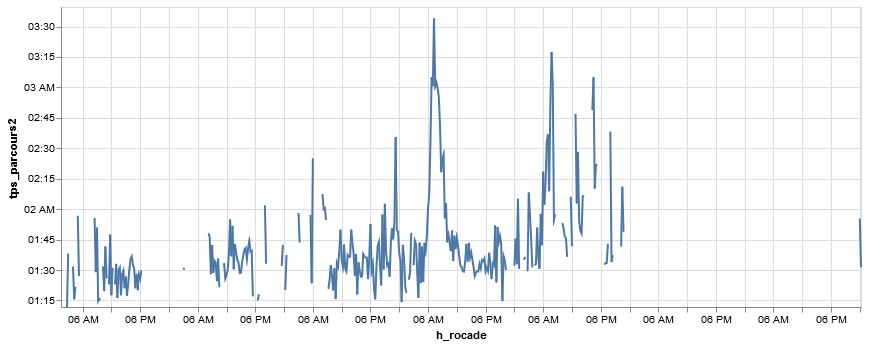

In [184]:
alt.Chart(pour_graph).mark_line().encode(
    x='h_rocade:T',
    y='tps_parcours2').properties(width=800)

In [ ]:
dico_od_final.loc[(dico_od_final['o_d']=='A10-A62') & (dico_od_final['date_cam_1']>pd.to_datetime('2019-01-28 21:00'))].sort_values('date_cam_1')

In [559]:
test=t.trajet(df_passages6.loc['2019-01-31 00:00:00':'2019-02-01 23:59:59'], '2019-01-31 08:15:00', 15, [8, 13],typeTrajet='Global',temps_max_autorise=18)

In [547]:
param_cluster=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [563]:
visu=t.jointure_temps_reel_theorique(test.df_transit,dixco_tpsmax_corrige,t.liste_complete_trajet, 15)

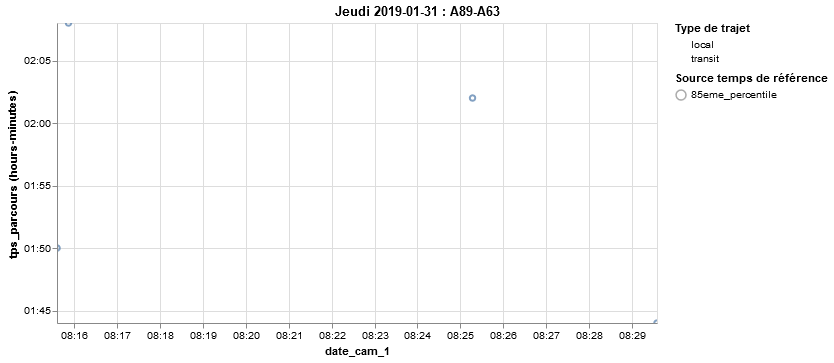

In [564]:
g.graph_transit_filtre(visu,'2019-01-31 00:00:00','2019-01-31 23:59:59','A89-A63')

# CORRIGER LES TEMPS DE PARCOURS LIMITES

In [1238]:
#isoler les données : sur un jour pour une o_d
o_d='A10-A63'
date='2019-02-06'
test_predict=df_transit_avec_filtre.loc[(df_transit_avec_filtre['o_d']==o_d) &
             (df_transit_avec_filtre.set_index('date_cam_1').index.dayofyear==pd.to_datetime(date).dayofyear)].copy()

In [1239]:
#ajouter des champsde ocnversion des dates en integer, limiter les valeusr sinon pb de mémoire avec sklearn
test_predict['date_int']=((test_predict.date_cam_1 - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))/1000000
test_predict['temps_int']=(((pd.to_datetime('2018-01-01')+test_predict.tps_parcours) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))/1000000

In [1074]:
#créer les données d'entrée du modele
X=np.array([[a,b] for a,b in zip(test_predict.date_int.tolist(),test_predict.temps_int.tolist())])
y=np.array(test_predict.filtre_tps.tolist())

In [1075]:
#créer le modele
ga=1000
C=35
clf = svm.SVC(kernel='rbf', gamma=ga, C=C)

In [1076]:
#alimenter le modele
clf.fit(liste_nsample_nfeat, n_sample)

SVC(C=35, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1077]:
#isoler les donner à tester
df_a_tester=test_predict.loc[(test_predict['filtre_tps']==0) & (test_predict['type']=='85eme_percentile')].copy()

In [1078]:
#liste à tester
liste_a_tester=np.array([[a,b] for a,b in zip(df_a_tester.date_int.tolist(),df_a_tester.temps_int.tolist())])
#dfde résultats de prédiction
df_type_predit=pd.DataFrame([[i, v] for i,v in zip(df_a_tester.index.tolist(),[clf.predict([x])[0] for x in liste_a_tester])], 
                            columns=['index_source','type_predit'])
#mise à jourde la df source
df_transit_avec_filtre.loc[df_transit_avec_filtre.index.isin(df_type_predit.index_source.tolist()),'type']='predit'
df_transit_avec_filtre.loc[df_transit_avec_filtre.index.isin(df_type_predit.loc[df_type_predit['type_predit']==1].index_source.tolist()),'filtre_tps']=1

In [1172]:
df_transit_avec_filtre.loc[df_transit_avec_filtre['type']=='predit']

,date_cam_1,immat,l,state,id,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,filtre_tps


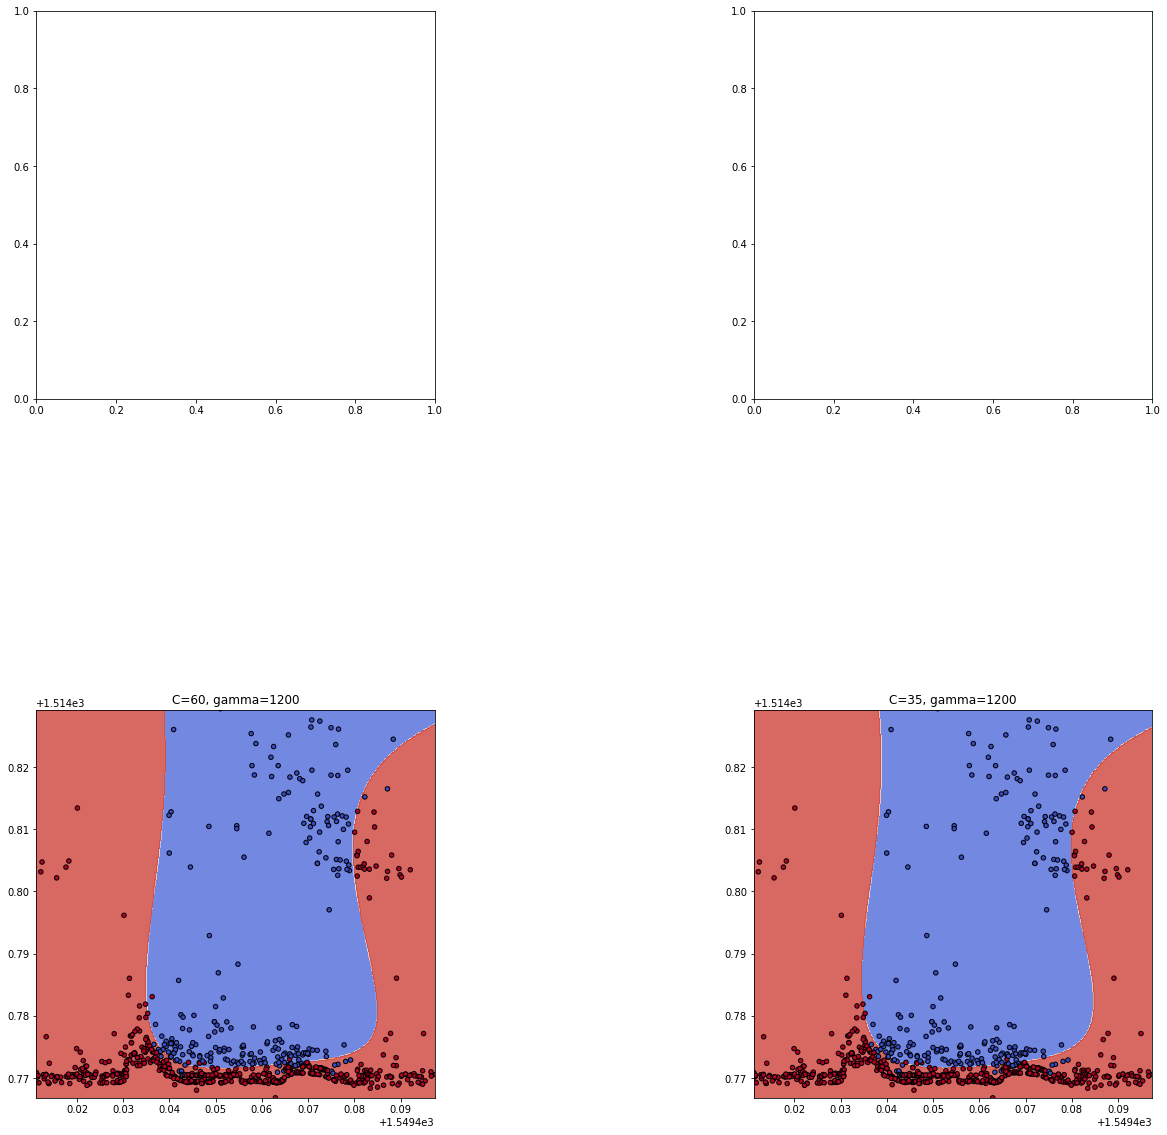

Wall time: 1.86 s


In [1240]:
%%time
def make_meshgrid(x, y, h=.0002):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 0.000000001, x.max() + 0.000000001
    y_min, y_max = y.min() - 0.000000001, y.max() + 0.000000001
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X=np.array([[a,b] for a,b in zip(test_predict.date_int.tolist(),test_predict.temps_int.tolist())])
y=np.array(test_predict.filtre_tps.tolist())
#C = 25# SVM regularization parameter
models = (svm.SVC(kernel='rbf', gamma=600, C=70),
         svm.SVC(kernel='rbf', gamma=600, C=35),
         svm.SVC(kernel='rbf', gamma=500, C=100),
         svm.SVC(kernel='rbf', gamma=500, C=200))
models = (clf.fit(X, y) for clf in models)


# Set-up 2x2 grid for plotting.
fig, sub = plt.figure(figsize=(20,20)).subplots(2,2)
plt.subplots_adjust(wspace=0.8, hspace=0.8)

# title for the plots
titles = ('C=60, gamma=1200',
          'C=35, gamma=1200',
          'C=100, gamma=500',
          'C=200, gamma=500')

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)

plt.show()

In [ ]:
liste_od_ok=['A660-A62','A62-A63','A63-A62','A62-A10','A660-N10', 'A660-A10','N10-A63','A62-N10']
for od in [x for x in df_transit_avec_filtre.o_d.unique().tolist() if x not in liste_od_ok ] : 
    for date in set([a[0].strftime('%Y-%m-%d') for a in t.creer_liste_date('2019-01-31',11)]):
        try : 
            df_transit_avec_filtre=t.predire_type_trajet(df_transit_avec_filtre,od, date,600,35)
        except ValueError : 
            continue

# VERIF AFFECTATION CLUSTER

vlaueError


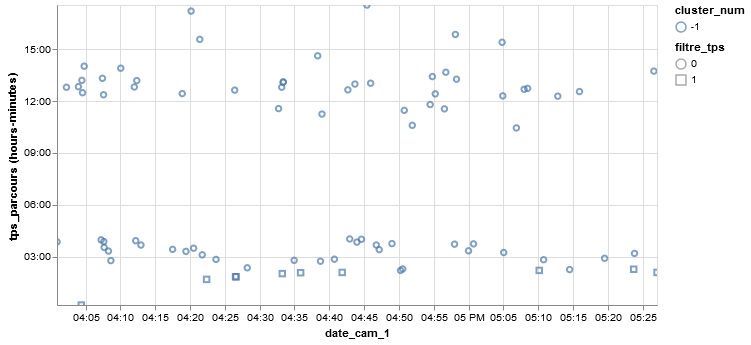

In [1237]:
#test cluster
od='A63-A10'
date_debut='2019-02-06 16:00:00'
datefin='2019-02-06 17:30:00'
delai=700
coeff=15
df_pl_ok=df_transit_avec_filtre.loc[(df_transit_avec_filtre['o_d']==od) &
                                   (df_transit_avec_filtre['date_cam_1'].between(pd.to_datetime(date_debut),pd.to_datetime(datefin)))]
donnees_src=df_pl_ok.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
liste_valeur=donnees_src.tps_parcours.apply(lambda x : ((pd.to_datetime('2018-01-01')+x)-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()#convertir les temps en integer
liste_date=donnees_src.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
if len(liste_valeur)<5 : #si il n'y a pas bcp de pl on arrete ; pourraitfair l'objet d'un parametre
    raise ClusterError()
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=delai, min_samples=len(liste_valeur)/coeff).fit(liste)

labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# A AMELIORER EN CREANT UNE ERREUR PERSONALISEE SI ON OBTIENT  CLUSTER
if n_clusters_== 0 :
    print('vlaueError')
#mettre en forme au format pandas
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,df_pl_ok, left_on='index_base', right_index=True )
graph_results=results[['date_cam_1','tps_parcours','filtre_tps','cluster_num']].copy()
graph_results.tps_parcours=pd.to_datetime('2018-01-01')+graph_results.tps_parcours
alt.Chart(graph_results).mark_point().encode(
                                x='date_cam_1',
                                y='hoursminutes(tps_parcours)',
                                tooltip='hoursminutes(tps_parcours)',
                                color='cluster_num:N',
                                shape='filtre_tps:N').interactive().properties(width=600)

In [1206]:
t.param_cluster

,delai,nb_pt_min,temps_etudie,trajet
0,600,4,15,"[A10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
1,1200,4,60,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
2,800,3,15,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
3,1000,4,60,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
4,1000,4,15,N10-A63
